# Bike Sharing Demand

## CRISP-DM Approach

CRISP-DM stands for Cross-Industry Standard Process for Data Mining and describes a structured approach to understanding, preparing, modeling and evaluating data. This process includes the following steps:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

Deployment is not relevant for this type of project, as I won't be deploying my model to a web server. However, my results will be summarized in a blog post on Medium (https://medium.com/@julia.nikulski).

### 1. Business Understanding

### 2. Data Understanding

The data set is provided by the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). The dataset was created originally created by Fanaee-T and Gama (2013) in their study ["Event labeling combining ensemble detectors and background knowledge"](https://link.springer.com/article/10.1007/s13748-013-0040-3). The bike demand data in this data set comes from [Capital Bike Share](http://capitalbikeshare.com/system-data), the weather data was taken from [Free Meteo](http://www.freemeteo.com) and the holiday data is from the [DC Department of Human Resources](http://dchr.dc.gov/page/holiday-schedule). The dataset used data from the bike sharing stations of Capital Bike Share in Washington, D.C., USA. The weather data and holiday data refers to the same location.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal, pearsonr
from sklearn.preprocessing import StandardScaler

import seaborn as sb
import matplotlib.pyplot as plt 

%matplotlib inline


### 3. Data Preparation

#### 3.1. Loading Data and visualizing and describing it

In [2]:
# read in bike sharing dataset
bike_df = pd.read_csv('bike-sharings.csv')
bike_df.head()


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [3]:
# print descriptive statistics
bike_df.describe()


,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [4]:
# check the datatypes of each variable
bike_df.dtypes


instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

Based on the source repository of the data set, these are the meanings of each variable:
- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- holiday : weather day is holiday or not
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit :
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered


##### Checking for missing values

In [5]:
# Check for missing values
bike_df.isnull().sum()


instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

#### 3.2. Preprocessing

Below I will engineer some new features based on the above overview of categorical and numeric variables

In [6]:
### dteday
# create new column with day of the month
bike_df['day'] = bike_df['dteday'].apply(lambda x: x[-2:])
bike_df['day'] = bike_df['day'].astype('int64')
# drop dteday feature
bike_df.drop(columns=['dteday'], axis=1, inplace=True)


In [7]:
### season
# create dummy variables for all 4 seasons
dummies_season = pd.get_dummies(bike_df['season'], prefix='season')

# remove season column from dataframe
bike_df.drop(columns=['season'], inplace=True)

# add dummy variables to dataframe
bike_df = pd.concat([bike_df, dummies_season], axis=1)

# change column names of the 4 season dummy variables
bike_df = bike_df.rename(columns={'season_1': 'season_spring', 'season_2': 'season_summer', 
                        'season_3': 'season_fall', 'season_4': 'season_winter'})


In [8]:
### weathersit
# create dummy variables for all 3 weathersit returns
dummies_weathersit = pd.get_dummies(bike_df['weathersit'], prefix='weathersit')

# remove season column from dataframe
bike_df.drop(columns=['weathersit'], inplace=True)

# add dummy variables to dataframe
bike_df = pd.concat([bike_df, dummies_weathersit], axis=1)

# change column names of the 3 weathersit dummy variables
bike_df = bike_df.rename(columns={'weathersit_1': 'weathersit_clear', 'weathersit_2': 'weathersit_mist', 
                        'weathersit_3': 'weathersit_rain'})


##### Dropping unnecessary columns

In [9]:
# drop the instant feature which is the same as the dataframe index +1
bike_df.drop(columns=['instant'], axis=1, inplace=True)


#### 3.3. Exploratory Data Analysis

#### Categorical and discrete variables

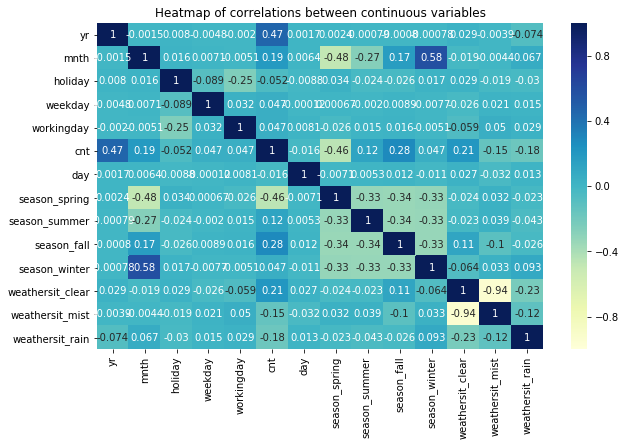

In [10]:
# create a correlation matrix
bike_df_corr_cat = bike_df.drop(columns=['temp', 'atemp', 'windspeed', 'hum', 'casual', 'registered'], axis=1)
bike_df_corr_cat = bike_df_corr_cat.corr(method='kendall')

# create a heatmap to visualize the results
plt.figure(figsize=[10,6])
sb.heatmap(bike_df_corr_cat, annot=True,
          vmin=-1, vmax=1, center=0,
          cmap='YlGnBu')
plt.title('Heatmap of correlations between continuous variables');


##### Season

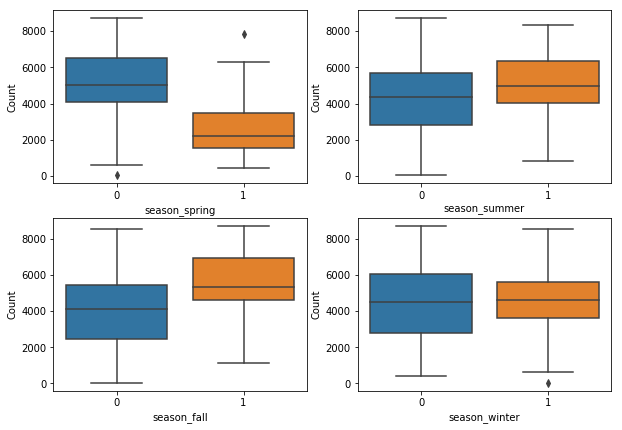

In [11]:
# variable to be used below to iterate through the columns and plot them
season_names = ['season_spring', 'season_summer', 'season_fall', 'season_winter']

# plotting the seasons vs. number of users in a boxplot
fig, ax = plt.subplots(2, 2, figsize = [10, 7])

count = 0

for j in range(len(ax)):
    for i in range(len(ax[j])):
        if j == 1 and i == 2:
            break
        else:
            ax[j][i] = sb.boxplot(data = bike_df, x = season_names[count], y = 'cnt', ax=ax[j][i])
            ax[j][i].set_ylabel('Count')
            ax[j][i].set_xlabel(season_names[count])
            
        count += 1


The season feature clearly determines the customer demand for bikes, so this feature will be used for the final model.

##### dteday

In [12]:
bike_df.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,day,season_spring,season_summer,season_fall,season_winter,weathersit_clear,weathersit_mist,weathersit_rain
0,0,1,0,6,0,0.344167,0.363625,0.805833,0.160446,331,654,985,1,1,0,0,0,0,1,0
1,0,1,0,0,0,0.363478,0.353739,0.696087,0.248539,131,670,801,2,1,0,0,0,0,1,0
2,0,1,0,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,3,1,0,0,0,1,0,0
3,0,1,0,2,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,4,1,0,0,0,1,0,0
4,0,1,0,3,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,5,1,0,0,0,1,0,0


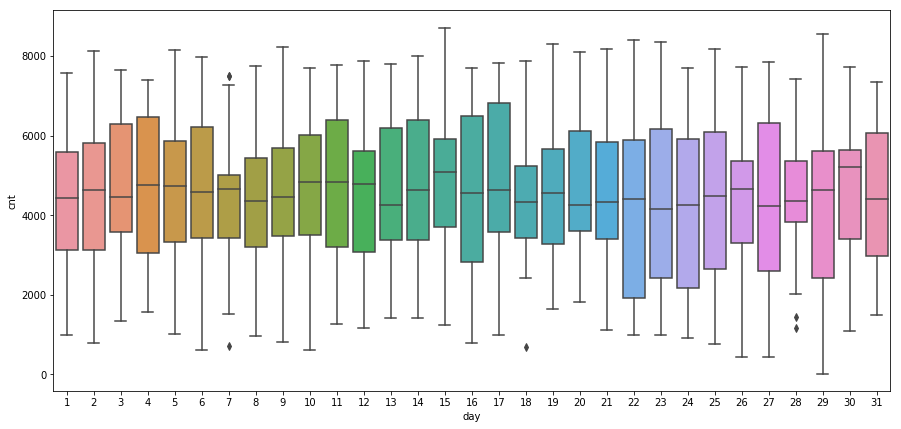

In [13]:
# plot number of users per day of month
plt.figure(figsize=[15,7])
sb.boxplot(x='day', y='cnt', data=bike_df);


There are slight differences in the average numbers of customers per day of the month. Certain days may be more predictive than others of the target variable. I will keep this variable for my model.

##### yr

In [14]:
# split dataframe into two years
yr_2011 = bike_df[bike_df['yr'] == 0]
yr_2012 = bike_df[bike_df['yr'] == 1]

x_2011 = yr_2011.groupby('mnth')['cnt'].mean().index
y_2011 = yr_2011.groupby('mnth')['cnt'].mean().values

x_2012 = yr_2012.groupby('mnth')['cnt'].mean().index
y_2012 = yr_2012.groupby('mnth')['cnt'].mean().values


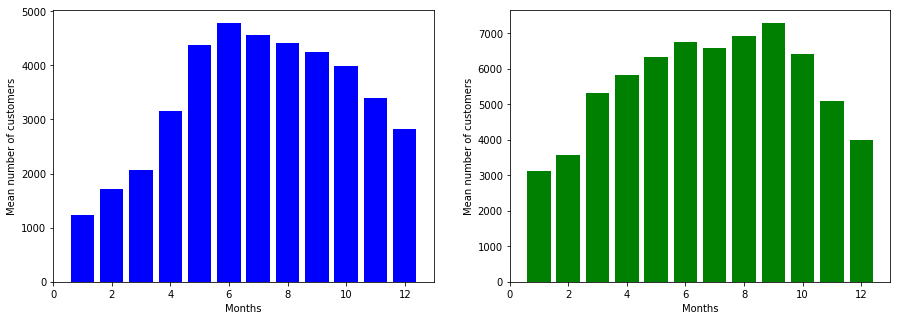

In [15]:
# plot count of customers for each year
plt.figure(figsize = [15, 5])

plt.subplot(1, 2, 1)
plt.bar(x_2011, y_2011, color='blue')
plt.xlabel('Months')
plt.ylabel('Mean number of customers')

plt.subplot(1, 2, 2)
plt.bar(x_2012, y_2012, color='green')
plt.xlabel('Months')
plt.ylabel('Mean number of customers');


The distribution of customers per month depends on the year. Thus, the feature yr should be kept for the final model.

##### mnth

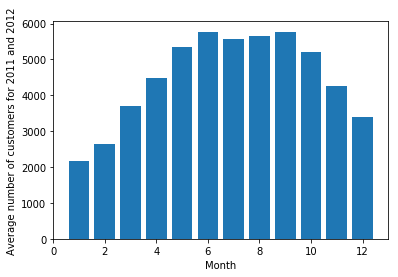

In [16]:
# plotting the total number of customers per month as a sum of both 2011 and 2012
mean_cnt_per_mnth = bike_df.groupby('mnth')['cnt'].mean()
x = mean_cnt_per_mnth.index
y = mean_cnt_per_mnth.values

plt.bar(x, y)
plt.xlabel('Month')
plt.ylabel('Average number of customers for 2011 and 2012');


The mnth feature shows differences in the average number of customers per month.

##### holiday

The features holiday, weekday and workingday have some overlaps in their prediction of customer demand, thus, I will first analyze each individual feature and then investigate their correlation.

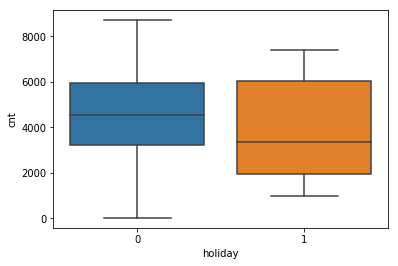

In [17]:
# plotting the customer statistics in form of a boxplot for the holiday feature
sb.boxplot(data = bike_df, x = 'holiday', y = 'cnt');


For the holiday feature, we can clearly see that there is on average a higher demand for bikes on days that are not holidays. This feature will be used in the final model to predict the overall demand.

In [18]:
# Correlation between holiday feature and the number of customers per day
# using the Kruskal Wallis H test for correlations between a continuous and categorical variable
kruskal(bike_df['holiday'], bike_df['cnt'])


KruskalResult(statistic=1237.4880012085603, pvalue=4.347245310989954e-271)

##### weekday

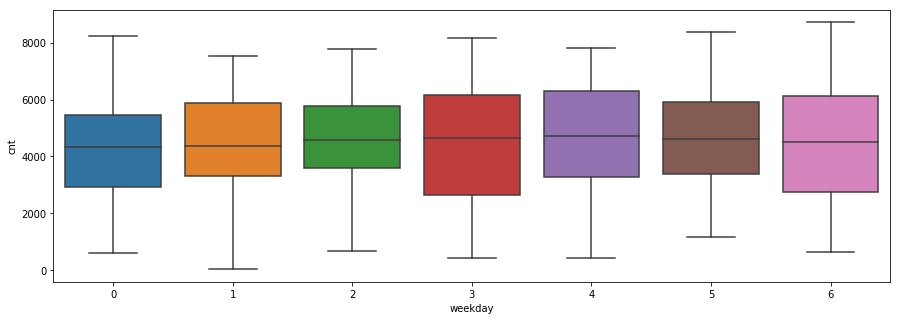

In [19]:
# plotting the customer statistics in form of a boxplot for the weekday feature
plt.figure(figsize = [15, 5])
sb.boxplot(data = bike_df, x = 'weekday', y = 'cnt');


In [20]:
# Correlation between weekday feature and the number of customers per day
# using Pearson's correlation coefficient because I'm assuming that weekday can be 
# considered a continuous variable
pearsonr(bike_df['weekday'], bike_df['cnt'])


(0.06744341241063048, 0.06839080695470057)

Based on the above distributions of number of customers per weekday, it appears that there are slight difference in demand depending on what weekday it is. Thus, the weekday will be considered to forecast the bike demand.

##### workingday

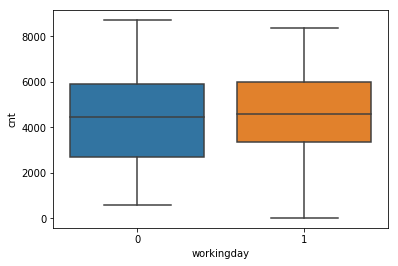

In [21]:
# plotting workday feature in boxplot against the count of customers
sb.boxplot(data = bike_df, x = 'workingday', y = 'cnt');


In [22]:
# Correlation between workingday feature and the number of customers per day
# using the Kruskal Wallis H test for correlations between a continuous and categorical variable
kruskal(bike_df['workingday'], bike_df['cnt'])


KruskalResult(statistic=1146.116725279893, pvalue=3.1322962418621962e-251)

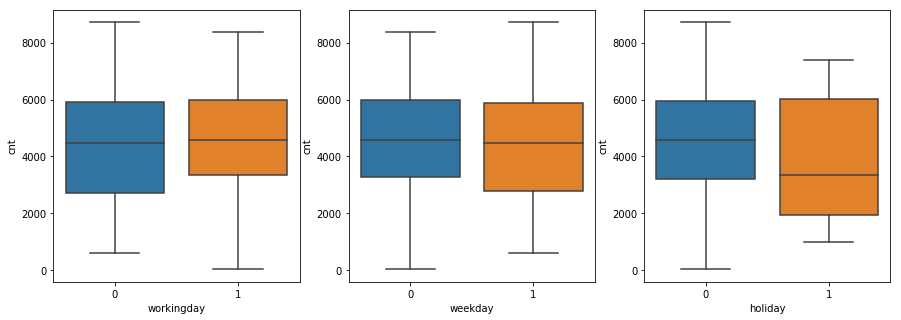

In [23]:
# create a new dataframe that encodes the weekday feature with 0 for monday through friday
# and 1 for saturday and sunday
weekend_distinct_df = bike_df.copy()
weekend_distinct_df['weekday'] = weekend_distinct_df['weekday'].apply(lambda x: 1 if (x == 6 or x == 0) else 0)

# plot boxplots for comparison between the weekday and workingday feature
plt.figure(figsize = [15, 5])

# boxplot for feature workingday
plt.subplot(1, 3, 1)
sb.boxplot(data = bike_df, x = 'workingday', y = 'cnt');

# boxplot for feature weekday
plt.subplot(1, 3, 2)
sb.boxplot(data = weekend_distinct_df, x = 'weekday', y = 'cnt');

# boxplot for feature holiday
plt.subplot(1, 3, 3)
sb.boxplot(data = bike_df, x = 'holiday', y = 'cnt');


In [24]:
# plot the means of each instance of workingday
bike_df.groupby('workingday')['cnt'].mean()


workingday
0    4330.168831
1    4584.820000
Name: cnt, dtype: float64

In [25]:
# plot the means of each instance of weekday
weekend_distinct_df.groupby('weekday')['cnt'].mean()


weekday
0    4550.566219
1    4389.685714
Name: cnt, dtype: float64

In [26]:
# plot the means of each instance of holiday
bike_df.groupby('holiday')['cnt'].mean()


holiday
0    4527.104225
1    3735.000000
Name: cnt, dtype: float64

The features holiday, weekday and workingday are correlated with each other as well as with the target variable cnt. However, they contain slightly different information that may be useful for predicting the target variable. Thus, I will keep all three variables for my model.

##### weathersit

The feature weathersit contains the following returns and meanings:
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

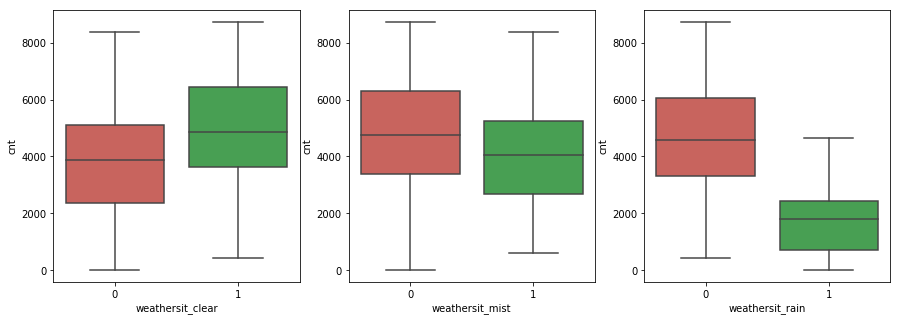

In [27]:
# plotting the weathersit vs. number of users in a boxplot
plt.figure(figsize = [15, 5])

# boxplot for feature workingday
plt.subplot(1, 3, 1)
sb.boxplot(data = bike_df, x = 'weathersit_clear', y = 'cnt',
          palette=[sb.xkcd_rgb["pale red"], sb.xkcd_rgb["medium green"]]);

# boxplot for feature weekday
plt.subplot(1, 3, 2)
sb.boxplot(data = bike_df, x = 'weathersit_mist', y = 'cnt',
          palette=[sb.xkcd_rgb["pale red"], sb.xkcd_rgb["medium green"]]);

# boxplot for feature holiday
plt.subplot(1, 3, 3)
sb.boxplot(data = bike_df, x = 'weathersit_rain', y = 'cnt',
          palette=[sb.xkcd_rgb["pale red"], sb.xkcd_rgb["medium green"]],);


As expected, the weathersit feature has a strong influence on the number of customers. 

#### Continuous variables

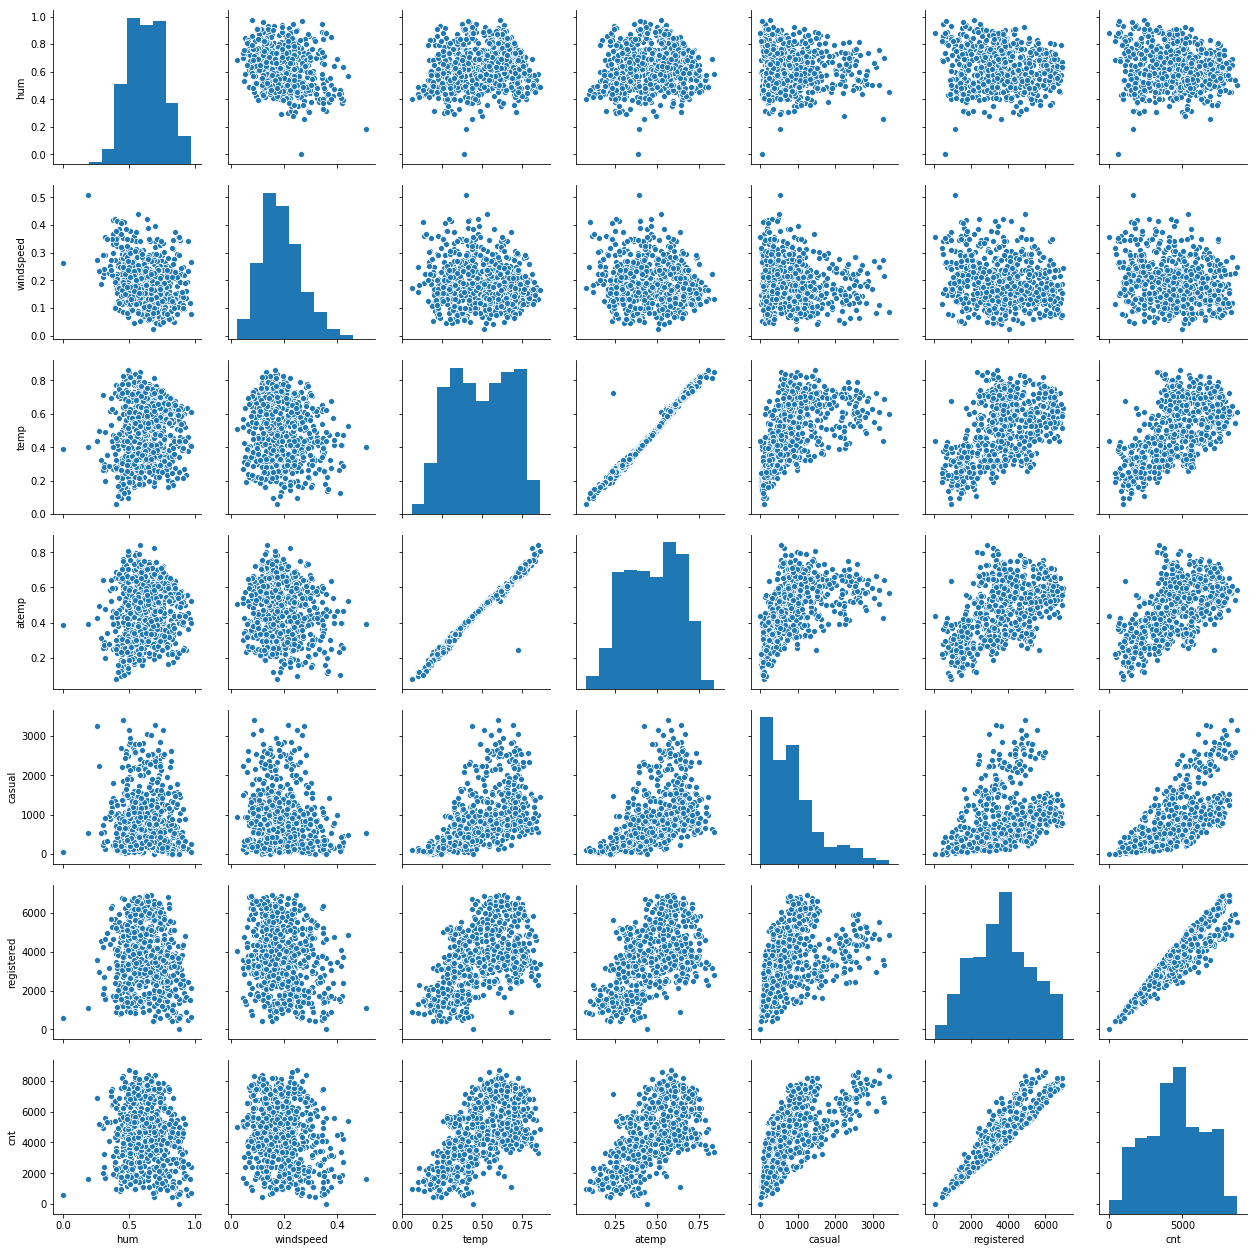

In [28]:
# plot all distributions and scatterplot between each continuous variable pair
sb.pairplot(bike_df, vars=['hum', 'windspeed', 'temp', 'atemp', 'casual', 'registered', 'cnt']);


Based on the results of the above pairplot, the following things are apparent:
* there does not seem to be a **linear relationship between hum and cnt**
* **windspeed and casual are left-skewed** variables and would need to be log transformed
* there is an almost **perfect linear relationship between atemp and temp**
* there exists a **linear relationship between registered and cnt**
* **casual and cnt** are related through a **logarithmic function**
* **temp and atemp** also have a **linear relationship with cnt**
* **hum and windspeed** seem to be **not very determinative of cnt**


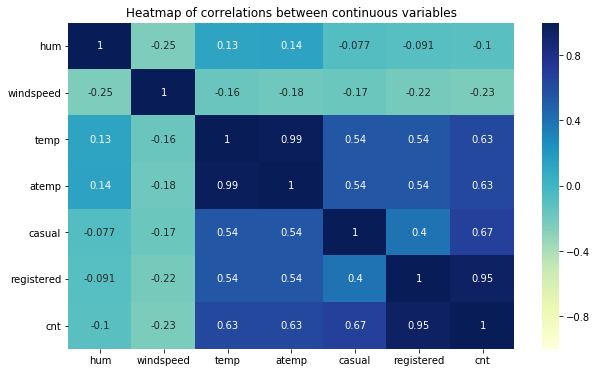

In [29]:
# create a correlation matrix
bike_df_corr = bike_df[['hum', 'windspeed', 'temp', 'atemp', 'casual', 'registered', 'cnt']].corr()

# create a heatmap to visualize the results
plt.figure(figsize=[10,6])
sb.heatmap(bike_df_corr, annot=True,
          vmin=-1, vmax=1, center=0,
          cmap='YlGnBu')
plt.title('Heatmap of correlations between continuous variables');


The heatmap underlines the indications of the pairplot and a number of steps need to be taken:
* atemp is perfectly correlated with temp, thus, atemp will be dropped from our dataset
* registered and casual are subsets of the cnt variables and do not lead to additional information, but rather to leakage, thus, both features will be dropped from the dataset
* hum and windspeed are only weakly, linearly correlated with cnt, however, I will keep them


##### temp

In [30]:
# create series that groups the mean temperature per month
temp_per_month = bike_df.groupby('mnth')['temp'].mean()
temp_per_month


mnth
1     0.236444
2     0.299226
3     0.390539
4     0.469999
5     0.594798
6     0.684097
7     0.755470
8     0.708582
9     0.616485
10    0.485012
11    0.369220
12    0.324031
Name: temp, dtype: float64

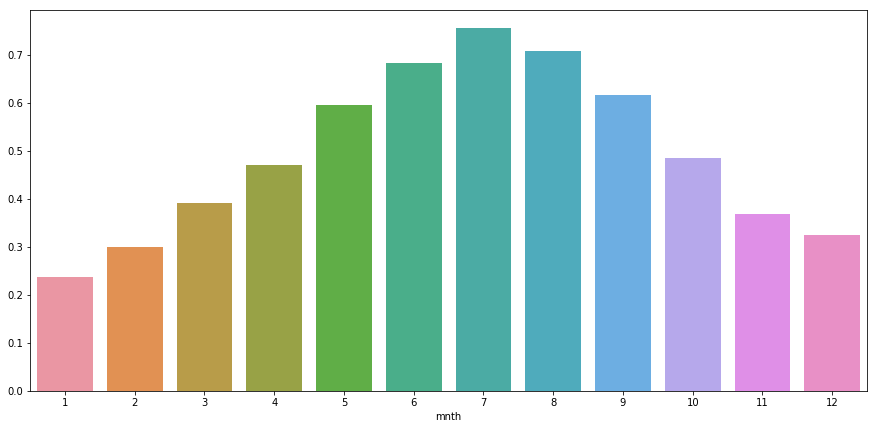

In [31]:
# plot number of users per day of month
plt.figure(figsize=[15,7])
sb.barplot(x=temp_per_month.index, y=temp_per_month.values);

In [32]:
# create series that groups average users per month
mean_cnt_per_mnth = bike_df.groupby('mnth')['cnt'].mean()
mean_cnt_per_mnth


mnth
1     2176.338710
2     2655.298246
3     3692.258065
4     4484.900000
5     5349.774194
6     5772.366667
7     5563.677419
8     5664.419355
9     5766.516667
10    5199.225806
11    4247.183333
12    3403.806452
Name: cnt, dtype: float64

<Figure size 1080x504 with 0 Axes>

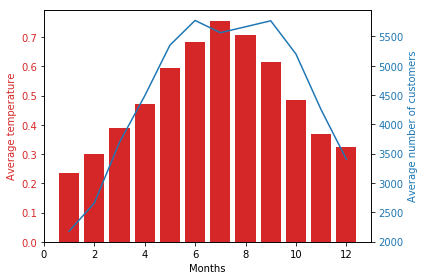

In [33]:
# assign x and y1 and y2
x = list(temp_per_month.index)
y1 = temp_per_month.values
y2 = mean_cnt_per_mnth.values

# below code adapted from https://matplotlib.org/gallery/api/two_scales.html
# creat plot containing both average count of customers
# and average temp per month
plt.figure(figsize=[15,7])
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color1 = 'tab:red'
ax1.set_xlabel('Months')
ax1.set_ylabel('Average temperature', color=color1)
ax1.bar(x, y1, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

color2 = 'tab:blue'
ax2.set_ylabel('Average number of customers', color=color2)
ax2.plot(x, y2, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout() 
plt.show()


From the above graph we can see that the month variable is correlated with the average number of customers per that month as well as the average temperature. The temperature strongly determines the number of customers. The temperature is likely a very important feature for predicting the target variable.

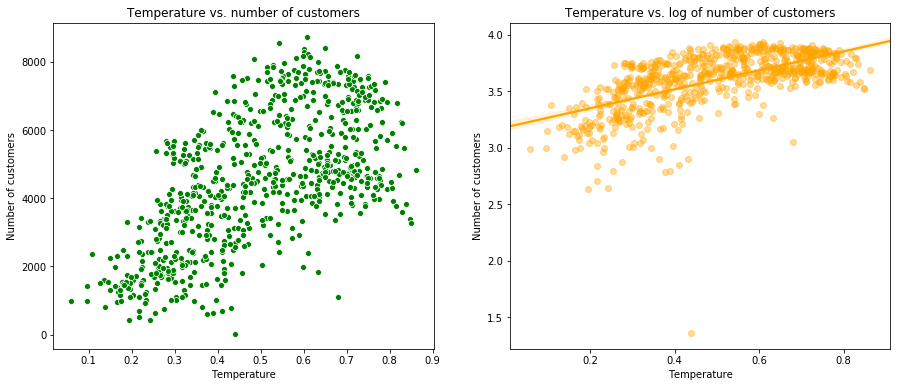

In [34]:
# plotting temp feature against the target label cnt
plt.figure(figsize=[15,6])

# plot with untransformed data
plt.subplot(1,2,1)
sb.scatterplot(data = bike_df, x = 'temp', y = 'cnt', color='green')
plt.xlabel('Temperature')
plt.ylabel('Number of customers')
plt.title('Temperature vs. number of customers');

# plot with log transformation of the temperature variable
plt.subplot(1,2,2)
sb.regplot(bike_df['temp'], bike_df['cnt'].apply(lambda x: np.log10(x + 1)), 
            scatter_kws={'alpha': 0.4}, color = 'orange')
plt.xlabel('Temperature')
plt.ylabel('Number of customers')
plt.title('Temperature vs. log of number of customers');


##### hum

##### windspeed

In [35]:
# log transform the windspeed feature based on above pairplot results
# this is a left-skewed distribution and thus, needs to be log transformed
bike_df['log_windspeed'] = bike_df['windspeed'].apply(lambda x: np.log(x + 1))


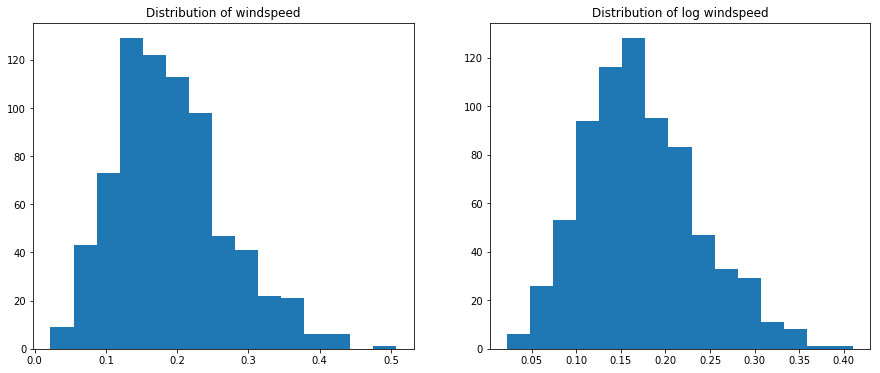

In [36]:
# plotting the distribution of windspeed and log windspeed
plt.figure(figsize=[15,6])

plt.subplot(1,2,1)
plt.hist(bike_df['windspeed'], bins=15)
plt.title('Distribution of windspeed')

plt.subplot(1,2,2)
plt.hist(bike_df['log_windspeed'], bins=15)
plt.title('Distribution of log windspeed');


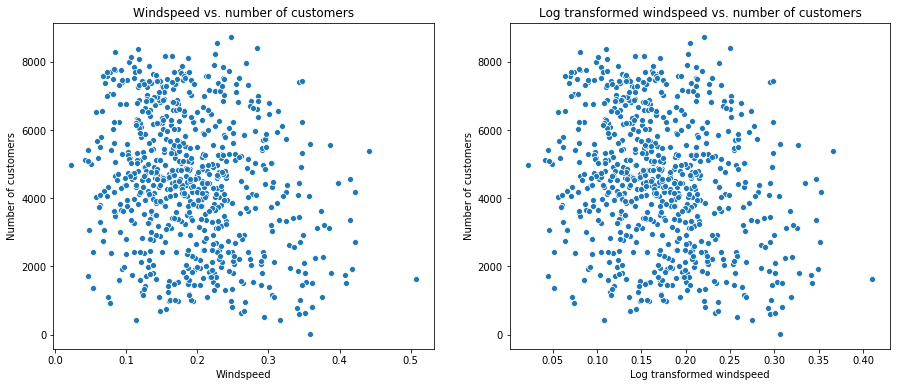

In [37]:
# scatterplot of log transformed windspeed vs. cnt target
plt.figure(figsize=[15,6])

plt.subplot(1,2,1)
sb.scatterplot(data = bike_df, x = 'windspeed', y = 'cnt')
plt.xlabel('Windspeed')
plt.ylabel('Number of customers')
plt.title('Windspeed vs. number of customers')

plt.subplot(1,2,2)
sb.scatterplot(data = bike_df, x = 'log_windspeed', y = 'cnt')
plt.xlabel('Log transformed windspeed')
plt.ylabel('Number of customers')
plt.title('Log transformed windspeed vs. number of customers');


Although windspeed is only correlated with cnt in a weak sense, I will keep this in the model. Because the distribution is left-skewed, I will use the log of windspeed in my model and drop the non-transformed windspeed as feature.

##### cnt

#### 3.4. Feature Selection

It is important to avoid look ahead bias and not to consider any features or data that we can only know in the future to predict the future. Checking this bias for all features that are still in the dataset:
* yr: 
* mnth:
* holiday:
* weekday:
* 

In [38]:
# drop columns that should not be used in our model
bike_df.drop(columns=['atemp', 'registered', 'casual', 'windspeed'], axis=1, inplace=True)


In [39]:
bike_df.head()

,yr,mnth,holiday,weekday,workingday,temp,hum,cnt,day,season_spring,season_summer,season_fall,season_winter,weathersit_clear,weathersit_mist,weathersit_rain,log_windspeed
0,0,1,0,6,0,0.344167,0.805833,985,1,1,0,0,0,0,1,0,0.148804
1,0,1,0,0,0,0.363478,0.696087,801,2,1,0,0,0,0,1,0,0.221974
2,0,1,0,1,1,0.196364,0.437273,1349,3,1,0,0,0,1,0,0,0.221790
3,0,1,0,2,1,0.200000,0.590435,1562,4,1,0,0,0,1,0,0,0.148675
4,0,1,0,3,1,0.226957,0.436957,1600,5,1,0,0,0,1,0,0,0.171345


Add additional dataset --> need to research papers and decide what to add

Use PCA maybe?

### 4. Model

Be careful --> this is time series data so I need to be careful when splitting the dataset

I may not need to split it when using pipelines, but I need to research how to do this

In [40]:
# assign X and y
y = bike_df['cnt']
X = bike_df.drop(columns=['cnt'], axis=1)


### 5. Evaluation